# Convolutional variational autoencoder for classification of Patch Camelyon images

In [2]:
# Tensorflow 
import tensorflow_datasets as tfds 
import tensorflow as tf 

# Additional
from matplotlib import pyplot as plt 
import numpy as np
from sklearn.metrics import mean_squared_error
import random

/Users/augustwennerwald/anaconda3/envs/amlfall23/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load data**

Similar approach as in AE part. 

In [3]:
d1, d2, d3 = tfds.load('patch_camelyon', split=[f'train[:10%]',f'test[:10%]',f'validation[:10%]'],
                          data_dir='./Data/PCAM', 
                          download=False, 
                          shuffle_files=True)

# Training data
d1_a, d1_b = d1.take(len(d1)//2), d1.skip(len(d1)//2)

# Test data 
d2_a, d2_b = d2.take(len(d2)//2), d2.skip(len(d2)//2)

# Valditation data 
d3_a, d3_b = d3.take(len(d3)//2), d3.skip(len(d3)//2)

print(f'Size of d1_a: {len(d1_a)} - size of d1_b: {len(d1_b)}')
print(f'Size of d2_a: {len(d2_a)} - size of d2_b: {len(d2_b)}')
print(f'Size of d3_a: {len(d3_a)} - size of d3_b: {len(d3_b)}')

Size of d1_a: 13107 - size of d1_b: 13107
Size of d2_a: 1638 - size of d2_b: 1639
Size of d3_a: 1638 - size of d3_b: 1639


In [4]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

d1_a, d1_b = d1_a.map(lambda x: convert_sample(x)[0]).batch(32), d1_b.map(convert_sample).batch(32)
d2_a, d2_b = d2_a.map(lambda x: convert_sample(x)[0]).batch(32), d2_b.map(convert_sample).batch(32)
d3_a, d3_b = d3_a.map(lambda x: convert_sample(x)[0]).batch(32), d3_b.map(convert_sample).batch(32)

In [5]:
train_images = d1.map(lambda x: convert_sample(x)[0]).batch(32)
validation_images = d3.map(lambda x: convert_sample(x)[0]).batch(32)
test_images = d2.map(lambda x: convert_sample(x)[0]).batch(32)

**Build variational autoencoder**

*Process of VAE*:
1. A encoder turns real image into mean and variance in the latent space.
2. A sampling layer takes such a mean and variance and use them to sample a random point from the latent space.
3. A decoder turns points the latent space back into recontructed images. 

In [5]:
# Encoder
latent_dim = 16

encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=3, strides = 1, padding='same', activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides= 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides= 2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2 * latent_dim), # 2 since we encode mean and standard deviation
])

encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 147456)            0         
                                                                 
 dense (Dense)               (None, 32)                4718624   
                                                                 
Total params: 5089440 (19.41 MB)
Trainable params: 5089440 (19.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# Decoder

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=24*24*32, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Reshape(target_shape= (24, 24, 32)),
    tf.keras.layers.Conv2DTranspose(256, kernel_size = 3, strides= 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, kernel_size = 3, strides= 1, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, kernel_size = 3, strides= 1, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size = 3, strides= 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(3,3, strides= 1, padding="same", activation="sigmoid")
])

# decoder = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(units=24*24*32, activation='relu', input_shape=(latent_dim,)),
#     tf.keras.layers.Reshape(target_shape=(24, 24, 32)), # To get in "image format"
#     tf.keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu'),
#     tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
#     tf.keras.layers.Conv2DTranspose(3, 3, 1, padding='same'),
# ])

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 18432)             313344    
                                                                 
 reshape (Reshape)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 48, 48, 256)       73984     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 48, 48, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 48, 48, 64)        73792     
 Transpose)                                                      
                                                      

In [36]:
# Variational autoencoder

class VAE(tf.keras.Model):
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.decoder = decoder
    
    def encode(self, x):
        params = self.encoder(x)
        return tf.split(params, num_or_size_splits=2, axis=1) # mean, logvar
        
    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return tf.sigmoid(self.decode(eps))

In [8]:
#Loss Function

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    vals = -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)

    return tf.reduce_sum(vals, axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [9]:
#Train step function

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [26]:
# Setupd model, optimizer and visualizations

model = VAE(latent_dim, encoder, decoder)
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
test_sample = next(iter(test_images.take(1)))[:16]

def generate_and_show_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0]) 
        plt.axis('off')

    # plt.savefig('./vae-img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [28]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 147456)            0         
                                                                 
 dense (Dense)               (None, 32)                4718624   
                                                                 
Total params: 5089440 (19.41 MB)
Trainable params: 5089440 (19.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
for epoch in range(1):
    for train_x in train_images:
        train_step(model, train_x, optimizer)

    loss = tf.keras.metrics.Mean()
    for test_x in test_images:
        loss(compute_loss(model, test_x))
    variational_lower_bound = -loss.result()

    print(f'Epoch: {epoch}, Test set variational lower bound: {variational_lower_bound}')
    generate_and_show_images(model, epoch, test_sample)

In [12]:
# Load encoder + weights 
encoder_pre_trained = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size= 3, strides = 1, padding='same', activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides= 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides= 2, padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(512, kernel_size=3, strides= 2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2 * latent_dim), # 2 since we encode mean and standard deviation
])

encoder_pre_trained.load_weights('./Saved_weights_prototypes/VAE_encoder_weights_180124.h5')

In [35]:
# Load decoder + weights 
decoder_pre_trained = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=24*24*32, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Reshape(target_shape= (24, 24, 32)),
    tf.keras.layers.Conv2DTranspose(256, kernel_size = 3, strides= 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, kernel_size = 3, strides= 1, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, kernel_size = 3, strides= 1, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size = 3, strides= 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(3,3, strides= 1, padding="same", activation="sigmoid")
])

decoder_pre_trained.load_weights('./Saved_weights_prototypes/VAE_decoder_weights_180124.h5')

In [37]:
# Compile VAE
VAE_pre_trained = VAE(latent_dim, encoder_pre_trained, decoder_pre_trained)

In [112]:
# Encode single image
def encodeImg(i):
     batch = next(iter(test_images))
     original_img = batch[0].numpy()
     original_img_reshaped = original_img.reshape((1,)+original_img.shape)
     mean, log_var = VAE_pre_trained.encode(original_img_reshaped)
     return mean, log_var

In [116]:
sample_mean, sample_log_var = encodeImg(1)
print(f'sample mean vector = {sample_mean.shape}')
print(f'samle log var vector = {sample_log_var.shape}')

sample mean vector = (1, 16)
samle log var vector = (1, 16)


In [106]:
def sample_VAE_reconstruction(idx = None):    
    fig = plt.figure(figsize=(10,10))
    
    batch = next(iter(test_images))
    if idx is None:
        idx = random.randint(0,len(batch))
    print(idx)
    
    original_img = batch[idx].numpy()
    fig.add_subplot(1,2,1)
    plt.imshow(original_img)
    plt.axis('off')

    original_img_reshaped = original_img.reshape((1,)+original_img.shape)
    
    mean, log_var = VAE_pre_trained.encode(original_img_reshaped)
    z = VAE_pre_trained.reparameterize(mean, log_var)
    reconstructed_img = VAE_pre_trained.sample(z)
    reconstructed_img_reshaped = np.reshape(reconstructed_img, (96,96,3))
    fig.add_subplot(1,2,2)
    plt.imshow(reconstructed_img_reshaped)
    plt.axis('off')

    

19


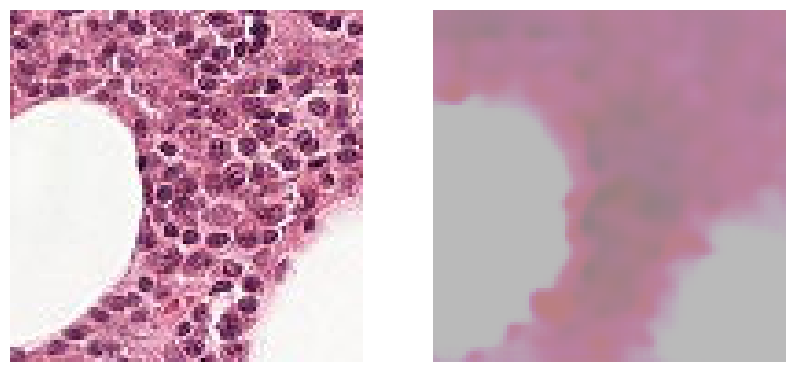

In [108]:
# idx = 19 yields a nice result ;) 
sample_VAE_reconstruction(19)

In [119]:
tf.random.normal(shape=(10, 16))

<tf.Tensor: shape=(10, 16), dtype=float32, numpy=
array([[-0.04426432,  1.8928635 ,  0.6197253 ,  1.7211447 , -1.0728018 ,
         0.07893427, -0.4767786 ,  0.54746264, -1.2619985 ,  0.22038868,
         1.8474094 ,  1.5264349 ,  1.2006516 ,  0.0932451 ,  0.6704861 ,
        -0.50910413],
       [ 0.5286888 ,  0.4494858 , -0.14994039, -0.9144961 ,  0.63020885,
        -0.04580981,  0.54127514, -1.0299608 ,  0.02578484,  0.7316154 ,
         0.32098946, -0.5589843 , -0.42256567, -0.41519183, -0.5001162 ,
         0.41976717],
       [-0.06046573, -1.0453886 , -0.16583721, -0.01163271,  0.35994598,
        -2.0899537 , -0.18514712,  1.2405077 ,  0.96416795,  0.84455824,
        -1.874554  , -0.3327237 ,  1.1813875 ,  0.25612104, -1.5327809 ,
         0.49890622],
       [-0.20211585,  0.9423676 , -0.5529939 ,  0.4524927 , -0.16506402,
         0.20121409,  1.3815181 , -0.59131336, -1.967485  , -0.01018296,
        -0.46343815,  0.95490974, -0.33919054, -0.03826068, -0.11291697,
        

In [11]:
# Test reshape 
def sample_reshape(idx = None, shape = [6,6], grayScale = True, normalize = False):    
    fig = plt.figure(figsize=(10,10))
    
    batch = next(iter(test_images))
    if idx is None:
        idx = random.randint(0,len(batch))
    print(idx)
    
    original_img = batch[idx].numpy()
    fig.add_subplot(1,2,1)
    plt.imshow(original_img)
    plt.axis('off')

    reshaped_img = tf.image.resize(original_img, shape)
    
    if grayScale: 
        reshaped_img = tf.image.rgb_to_grayscale(reshaped_img)

    if normalize: 
        reshaped_img = reshaped_img / 255 

    fig.add_subplot(1,2,2)
    plt.imshow(reshaped_img, cmap='gray')
    plt.axis('off')

    print(f'Size of reshaped image: {reshaped_img.shape}')


19
Size of reshaped image: (32, 32, 1)


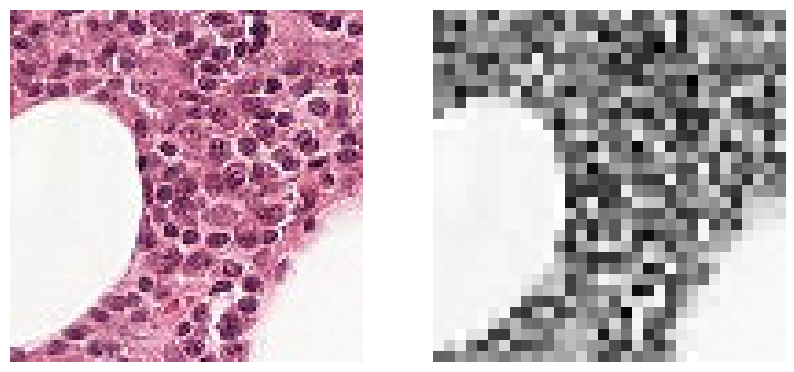

In [12]:
sample_reshape(19, shape = [32,32])